<a href="https://colab.research.google.com/github/Swapnil-Datta/SIGNATURE-VERIFICATION-MODEL/blob/main/SignatureVerification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Signature Verification and Frawd Detection Model**

##To Get The Database From The Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import shutil

# Step 3: Define source and destination paths
source_path = '/content/drive/MyDrive/JOB/archive.zip'
destination_path = '/content/archive.zip'

#Move the folder
#shutil.move(destination_path, source_path)
#Copy the folder
shutil.copy(source_path, destination_path)

print(f'Folder copy from {source_path} to {destination_path}')

Folder copy from /content/drive/MyDrive/JOB/archive.zip to /content/archive.zip


In [3]:
# prompt: extract a file

import zipfile
with zipfile.ZipFile('/content/archive.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')
print(f'Folder Extracted')

Folder Extracted


In [4]:
import os
import shutil

def delete_non_empty_folder(folder_path):
  for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
      os.remove(file_path)
    elif os.path.isdir(file_path):
      delete_non_empty_folder(file_path)
  os.rmdir(folder_path)

# Example usage
delete_non_empty_folder("/content/sign_data/sign_data")

## 1. Main

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
import os
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

ImportError: cannot import name 'ImageDataGenerator' from 'keras.preprocessing.image' (/usr/local/lib/python3.10/dist-packages/keras/api/preprocessing/image/__init__.py)

In [ ]:
!mkdir Train
!mkdir Test

!mkdir Train/Fake
!mkdir Train/Real

!mkdir Test/Fake
!mkdir Test/Real

In [ ]:
PATH = "/content/sign_data/train/"
for i in os.listdir(PATH):
    contol = i.split("_")
    if len(contol) > 1 and contol[1]=="forg": # Check if list has at least two elements
        print(contol)
        os.system("cp -r {} Train/Fake".format(PATH+i))
    else:
        os.system("cp -r {} Train/Real".format(PATH+i))

In [ ]:
PATH = "/content/sign_data/test/"
for i in os.listdir(PATH):
    contol = i.split("_")
    if len(contol) > 1 and contol[1]=="forg": # Check if list has at least two elements
        print(contol)
        os.system("cp -r {} Test/Fake".format(PATH+i))
    else:
        os.system("cp -r {} Test/Real".format(PATH+i))

In [ ]:
train_dir = os.path.join("/content/Train")

test_dir = os.path.join("/content/Test")

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(200, 200),
        batch_size=64,

        class_mode='binary')

In [ ]:
test_generator = test_datagen.flow_from_directory(

        test_dir,

        target_size=(200, 200),

        batch_size=64,

        class_mode='binary')

In [ ]:
x = 5
y = 30
plt.imshow(train_generator[x][0][y])
print("Label : ",train_generator[x][1][y])

In [ ]:
# prompt: write a code to post process all the images (convert to gray scale)

import cv2

def preprocess_image(image):
  """
  Converts the image to grayscale.

  Args:
    image: A 3D numpy array representing the image.

  Returns:
    A 2D numpy array representing the grayscale image.
  """
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return gray_image

def preprocess_all_images(generator):
  """
  Preprocesses all images in the generator.

  Args:
    generator: A Keras ImageDataGenerator object.

  Returns:
    A new Keras ImageDataGenerator object with preprocessed images.
  """
  new_generator = ImageDataGenerator()
  for x, y in generator:
    new_x = [preprocess_image(image) for image in x]
    new_generator.fit(np.array(new_x), y)
  return new_generator

train_generator = preprocess_all_images(train_generator)
test_generator = preprocess_all_images(test_generator)



## 2. Test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.color import rgb2gray
from keras.preprocessing.image import ImageDataGenerator
import cv2

In [ ]:
# Function to visualize images
def visualize_before_after(original, original_name, processed, process_name):
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.title(original_name)
    plt.imshow(original, cmap='gray')
    plt.axis('off')

    # Processed image
    plt.subplot(1, 2, 2)
    plt.title(process_name)
    plt.imshow(processed, cmap='gray')
    plt.axis('off')

    plt.show()

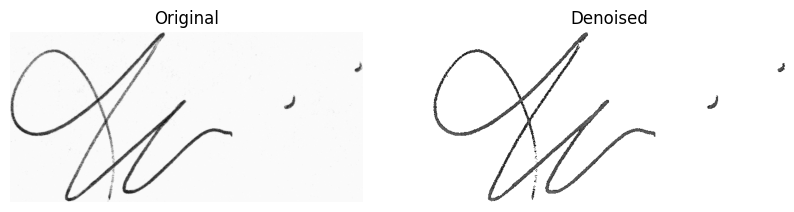

In [ ]:
def remove_noise(image):
    # Threshold value using Otsu's method
    #T = cv2.threshold((image * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[0]
    # Threshold value using Otsu's method
    T = cv2.threshold((image * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # Logical index of pixels to keep (exclude spark component)
    logInd = image * 255 > T

    # Initialize R, G, B channels with bluish values
    R = np.full(image.shape, 5, dtype=np.uint8)
    G = np.full(image.shape, 3, dtype=np.uint8)
    B = np.full(image.shape, 20, dtype=np.uint8)

    # Get original pixels without sparks
    R[logInd] = (image * 255)[logInd]
    G[logInd] = (image * 255)[logInd]
    B[logInd] = (image * 255)[logInd]

    # Concatenate Red, Green, Blue channels
    rgbImage = np.stack((R, G, B), axis=-1)

    # Convert back to grayscale for visualization
    denoised_image = rgb2gray(rgbImage)

    return denoised_image

# Load an example image using OpenCV
image_path = '/content/sign_data/test/049/01_049.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image_rescaled = image / 255.0  # Rescale to [0, 1] range

# Apply the denoise preprocessing function
denoised_image = remove_noise(image_rescaled)

#Invert the black and white of image
denoised_image =  1- denoised_image

# Visualize the original and thinned images
visualize_before_after(image_rescaled, 'Original', denoised_image, 'Denoised')

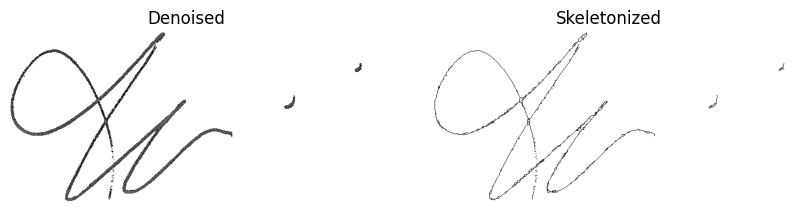

In [ ]:

image = denoised_image

# Check if the image is loaded correctly
if image is None:
    print("Failed to load image.")
else:
    # Convert the image to 8-bit grayscale
    image_8bit = (image * 255).astype(np.uint8)  # Convert to 8-bit

    # Apply adaptive thresholding
    binary_image = cv2.adaptiveThreshold(image_8bit, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY_INV, 11, 2)

    # Skeletonize the binary image
    skeletonized_image = skeletonize(binary_image / 255).astype(np.uint8) * 255

    #Invert the black and white of image
    skeletonized_image = 255 - skeletonized_image

    # Visualize the original, binary, and skeletonized images
    visualize_before_after(image_8bit, 'Denoised', skeletonized_image, 'Skeletonized')


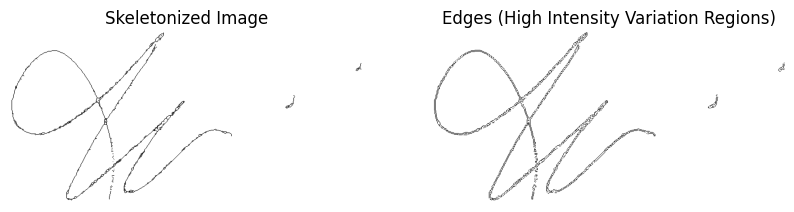

In [ ]:

# Check if the image is loaded correctly
if skeletonized_image is None:
    print("Failed to load skeletonized image.")
else:
    # Step 1: Detect edges using Canny edge detection on the skeletonized image
    edges = cv2.Canny(skeletonized_image, 50, 150)

    # Step 2: Extract features from the edges (high variation regions)
    features = []

    # Iterate over each high variation region
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        # Extract features from each region (example: perimeter)
        perimeter = cv2.arcLength(contour, True)
        features.append(perimeter)

    # Display the skeletonized image and the detected edges

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(skeletonized_image, cmap='gray')
    plt.title('Skeletonized Image')
    plt.axis('off')

    edges = 255 - edges  # Invert the edges for visualization
    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.title('Edges (High Intensity Variation Regions)')
    plt.axis('off')

    plt.show()


Skeletonized image shape: (323, 670)
Skeletonized image values (min, max): 0 255
Cross-over loops shape: (323, 670, 3)
Cross-over loops values (min, max): 0 255


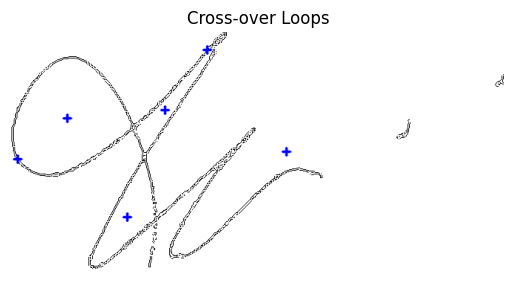

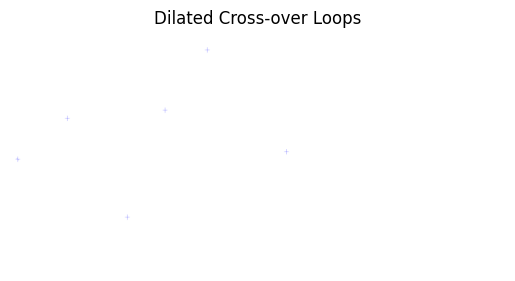

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Function to detect cross-over loops
def detect_cross_over_loops(edges):
    # Apply morphological dilation to thicken lines
    dilated_image = cv2.dilate(edges, np.ones((3, 3), dtype=np.uint8), iterations=1)

    # Apply morphological erosion to thin the lines slightly
    eroded_image = cv2.erode(edges, np.ones((3, 3), dtype=np.uint8), iterations=1)

    # Perform bitwise AND operation between the dilated and eroded images to find intersections
    cross_over_loops = cv2.bitwise_and(dilated_image, eroded_image)

    return cross_over_loops

def detect_cross_over_loops(edges):
    # Apply morphological dilation to thicken lines
    dilated_image = cv2.dilate(edges, np.ones((3, 3), dtype=np.uint8), iterations=1)

    # Apply morphological erosion to thin the lines slightly
    eroded_image = cv2.erode(edges, np.ones((3, 3), dtype=np.uint8), iterations=1)

    # Perform bitwise AND operation between the dilated and eroded images to find intersections
    cross_over_loops = cv2.bitwise_and(dilated_image, eroded_image)

    # Find contours in the cross_over_loops image
    contours, _ = cv2.findContours(cross_over_loops, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw crosses on the original edges image
    result_image = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)  # Convert to BGR for colored drawing

    for contour in contours:
        # Get the moments to find the center of the contour
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            continue

        # Draw a cross at the center of the contour
        cv2.drawMarker(result_image, (cX, cY), (0, 0, 255), markerType=cv2.MARKER_CROSS,
                       markerSize=10, thickness=2, line_type=cv2.LINE_AA)

    return result_image

# Example usage:
# Load the skeletonized image (replace 'edges.npy' with your file path)
#edges = np.load('edges.npy')

print("Skeletonized image shape:", edges.shape)
print("Skeletonized image values (min, max):", np.min(edges), np.max(edges))

# Detect cross-over loops
cross_over_loops = detect_cross_over_loops(edges)

print("Cross-over loops shape:", cross_over_loops.shape)
print("Cross-over loops values (min, max):", np.min(cross_over_loops), np.max(cross_over_loops))

# Visualize the cross-over loops
plt.imshow(cross_over_loops, cmap='gray')
plt.title('Cross-over Loops')
plt.axis('off')
plt.show()

# Dilate the detected cross-over loops to make them more visible
dilated_cross_over_loops = cv2.dilate(cross_over_loops, np.ones((5, 5), dtype=np.uint8), iterations=1)

# Visualize the dilated cross-over loops
plt.imshow(dilated_cross_over_loops, cmap='gray')
plt.title('Dilated Cross-over Loops')
plt.axis('off')
plt.show()




In [5]:
!git --version

git version 2.34.1


In [6]:
!git clone https://github.com/Swapnil-Datta/SIGNATURE-VERIFICATION-MODEL.git

Cloning into 'SIGNATURE-VERIFICATION-MODEL'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 7.10 KiB | 7.10 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [11]:
!mv SignatureVerification.ipynb /content/SIGNATURE-VERIFICATION-MODEL

mv: cannot stat 'SignatureVerification.ipynb': No such file or directory
